In [1]:
# Idea inspired by https://arxiv.org/abs/1806.07366 (?)


Given our problem:

$$
\frac{\partial \rho}{\partial t} = \sigma_1 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(v_m(1-2\rho) \right)
$$

$$
\sigma_1 \frac{\partial \rho}{\partial x_1} - \rho v_m(1-\rho) = -a (\rho_{max} - \rho) \quad x = 0 
$$

$$
-\sigma_1 \frac{\partial \rho}{\partial x_1} + \rho v_m(1-\rho)= b \rho \quad x = L
$$

At steady-state:

$$
\frac{\partial \rho}{\partial t} = 0
$$

And so
$$
\sigma_1 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(v_m(1-2\rho) \right) = 0
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [3]:
model_key = jax.random.PRNGKey(1)

input_dim = 'scalar'
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [54]:
sigma2 = 0.5**2

L = 3.0


a = 0.9
b = 0.975

v_max = 2.7
p_max = 1 # rho_max cannot be learned Susana's paper

In [55]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [56]:
def cosine_spacing(start, end, steps):
    linspace = jnp.linspace(0, jnp.pi, steps)
    cosine_values = (1 - jnp.cos(linspace))/2  # This maps the values to [0, 1]
    return start + (end - start) * cosine_values

In [57]:
def loss(model, sigma2, L, a, b, steps=50):

    x_flat = cosine_spacing(0, L, steps)
    inputs = jnp.concat([x_flat, jnp.array([0.0]), jnp.array([L])])
    

    rho, grad = jax.vmap(jax.value_and_grad(model))(inputs)
    hess = jax.vmap(jax.hessian(model))(inputs)

    dp_dx = grad
    d2p_dx2 = hess

    # PDE Loss
    pde_loss = sigma2*d2p_dx2 - dp_dx*(v_max*(1-2*rho))

    # in loss
    in_loss = sigma2*dp_dx[-2] - rho[-2]*v_max*(1-rho[-2]) + a*(1-rho[-2])

    # out loss
    out_loss = -sigma2*dp_dx[-1] + rho[-1]*v_max*(1-rho[-1]) - b*rho[-1]

    return jnp.average(pde_loss**2) + in_loss**2 + out_loss**2


In [58]:
loss(model, sigma2, L, a, b)

Array(0.19105121, dtype=float32)

In [59]:
def custom_activation(y):
    # Ensure the input is within the valid range to avoid domain errors
    y = jnp.clip(y, -0.99, 0.99)
    return 0.5 * jnp.log((1 + y) / (1+jnp.abs(1 - y)))

In [60]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.mish(layer(x))
        
        x = self.layers[-1](x)
        return x

In [61]:
class ResNet(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.

    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the ResNet

        Args:
            key (jax key): Random Key
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (int): Number of hidden layers
            output_dim (int): Output layer dimension
        """
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    def __call__(self, x):
        """Forward-pass the input through the network with residual connections

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for i, layer in enumerate(self.layers[:-1]):
            if i % 2 == 0 and i != 0:
                x = x + prev_x  # Add the previous input for residual connection
            prev_x = x
            x = jax.nn.sigmoid(layer(x))
        
        x = self.layers[-1](x)
        return x

In [62]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, L, sigma2, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, sigma2, L, a, b) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [63]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)

input_dim = 'scalar'
output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=4, n_layers=4, output_dim=output_dim)

In [72]:
# Optimizer definition
lr = 10e-4
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [73]:
# Training loop
num_epochs = 30000
losses = []

sigma2 = 0.5**2
sigma2_target = 0.1
n_sigma = int(num_epochs/100)
i = 0
ss = jnp.linspace(sigma2,sigma2_target, n_sigma)

for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, L, sigma2, a, b, steps=200)

    if epoch % 100 == 0:
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")
        i += 1
        #sigma2 = ss[i]
        
    if epoch % 1000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate



# Print final loss
final_loss = loss(model, L, sigma2, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 0.005907747428864241
Epoch 100, Loss: 0.0059057301841676235
Epoch 200, Loss: 0.005904024001210928
Epoch 300, Loss: 0.0059016430750489235
Epoch 400, Loss: 0.005898620933294296
Epoch 500, Loss: 0.005895446985960007
Epoch 600, Loss: 0.005891748704016209
Epoch 700, Loss: 0.005887725856155157
Epoch 800, Loss: 0.005883305799216032
Epoch 900, Loss: 0.005878622643649578
Epoch 1000, Loss: 0.00587341096252203
Epoch 1100, Loss: 0.005871411878615618
Epoch 1200, Loss: 0.005869362037628889
Epoch 1300, Loss: 0.005867019295692444
Epoch 1400, Loss: 0.005863934755325317
Epoch 1500, Loss: 0.005860458128154278
Epoch 1600, Loss: 0.005856665316969156
Epoch 1700, Loss: 0.005852490663528442
Epoch 1800, Loss: 0.005847662687301636
Epoch 1900, Loss: 0.005842810496687889
Epoch 2000, Loss: 0.00583734130486846
Epoch 2100, Loss: 0.00583510659635067
Epoch 2200, Loss: 0.005833059083670378
Epoch 2300, Loss: 0.005830321926623583
Epoch 2400, Loss: 0.005827216897159815
Epoch 2500, Loss: 0.005823501851409674

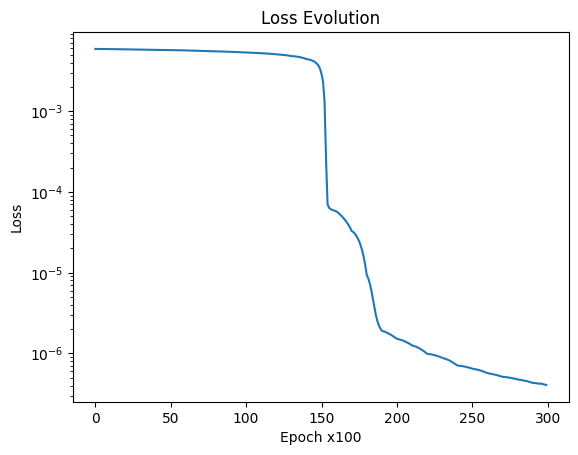

In [74]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [68]:
#res_05 = outputs

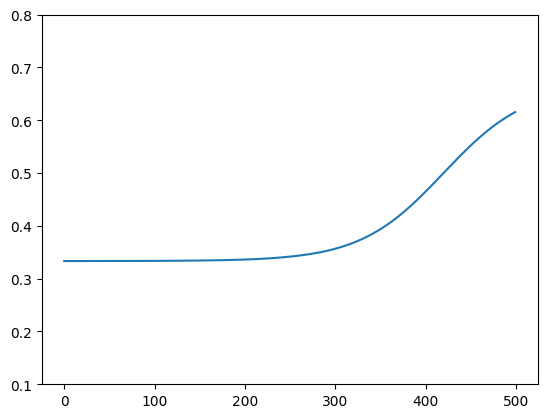

In [75]:
x_flat = jnp.linspace(0, L, 500)
outputs = jax.vmap(model)(x_flat)

plt.plot(outputs)
#plt.plot(res_05)
plt.ylim([0.1, 0.8])
plt.show()

In [76]:
def get_weights(model):
    weights = []
    for layer in model.layers:
        weights.append(layer.weight)
    return weights

In [23]:
#trained_weights_15 = get_weights(model)
trained_weights_15

[Array([[ 1.0596178 ],
        [-0.44736302],
        [-0.68521196],
        [-0.565549  ]], dtype=float32),
 Array([[-0.17298228,  0.8841624 ,  0.22569665,  0.39481416],
        [-0.13314998, -0.18485181,  0.33994904,  0.16126776],
        [ 0.03072917,  0.32190248,  0.58577627, -0.6250462 ],
        [ 0.45974353,  1.1454675 ,  0.47788265,  0.70734036]],      dtype=float32),
 Array([[-0.33807167,  0.525232  ,  0.5043887 , -0.39541814],
        [-0.6221204 ,  0.05184008, -0.12415724, -1.3920519 ],
        [ 0.48048645,  0.4489588 ,  0.40015188, -0.36377138],
        [ 0.18731272,  0.7513014 ,  0.8051817 ,  0.14068326]],      dtype=float32),
 Array([[-1.0861645 ,  0.3257358 , -0.66240525,  0.30426377],
        [ 0.7262845 , -0.25629887,  0.02190049,  0.32309386],
        [ 0.6902374 ,  0.10812131,  0.46093065,  0.4441268 ],
        [-0.89317477,  0.74946445, -0.8695133 , -0.15031508]],      dtype=float32),
 Array([[-0.8105052 ,  0.64833456,  0.23405978, -0.7654243 ]], dtype=float32)]

In [40]:
#trained_weights_14 = get_weights(model)
trained_weights_14

[Array([[ 0.93385595],
        [-0.49872112],
        [-0.776284  ],
        [-0.5552859 ]], dtype=float32),
 Array([[-0.25801656,  0.85642326,  0.2961412 ,  0.32772648],
        [-0.14869079, -0.3547818 ,  0.36909753,  0.1810419 ],
        [ 0.02522978,  0.29815617,  0.64508176, -0.71165967],
        [ 0.4599936 ,  1.1179985 ,  0.47261152,  0.7105125 ]],      dtype=float32),
 Array([[-0.3224796 ,  0.5945921 ,  0.58557475, -0.4513523 ],
        [-0.88597256, -0.9433289 , -0.119699  , -2.097181  ],
        [ 0.44306403,  0.45090294,  0.36492342, -0.39333257],
        [ 0.20858665,  0.79989207,  0.89533526,  0.0964454 ]],      dtype=float32),
 Array([[-1.1069872 ,  0.11471776, -0.7876751 ,  0.28527948],
        [ 0.86798334, -0.09788066,  0.02925325,  0.3710884 ],
        [ 0.85265017,  0.28275466,  0.6038414 ,  0.52436644],
        [-0.83385175,  0.4739598 , -0.93709874, -0.13281468]],      dtype=float32),
 Array([[-0.7676016 ,  0.6215346 ,  0.38430035, -1.1761361 ]], dtype=float32)]

In [47]:
jnp.linalg.norm(jnp.array(trained_weights_14[0].flatten()),jnp.array(trained_weights_15[0].flatten()))

ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'jaxlib.xla_extension.ArrayImpl'>, [ 1.0596178  -0.44736302 -0.68521196 -0.565549  ]. The error was:
TypeError: unhashable type: 'jaxlib.xla_extension.ArrayImpl'


In [51]:
jnp.sqrt(jnp.sum((trained_weights_14[0]-trained_weights_15[0])**2))

Array(0.16386926, dtype=float32)

In [52]:
jnp.sqrt(jnp.sum((trained_weights_14[1]-trained_weights_15[1])**2))

Array(0.24541287, dtype=float32)

In [53]:
jnp.sqrt(jnp.sum((trained_weights_14[2]-trained_weights_15[2])**2))

Array(1.2603164, dtype=float32)

In [77]:
#trained_weights_27 = get_weights(model)
trained_weights_27

[Array([[ 1.1848702 ],
        [-0.56646764],
        [-1.6314828 ],
        [-0.7950644 ]], dtype=float32),
 Array([[ 0.22652012,  0.72692746, -0.47854367,  0.75541484],
        [ 0.29648235, -0.3059581 , -0.44507766,  0.7146783 ],
        [-0.9584553 ,  0.6519268 , -0.6531801 ,  5.8594813 ],
        [ 0.5406875 ,  1.0317189 , -0.55976593,  0.8633731 ]],      dtype=float32),
 Array([[ 0.03487471,  0.647956  , -0.20573185,  0.46085098],
        [-0.42881837,  0.3406453 ,  0.20427062, -0.45131075],
        [ 0.8984702 ,  0.22545823,  0.36466193,  0.7261899 ],
        [ 0.47540715,  0.5470714 ,  0.43285576,  0.87255955]],      dtype=float32),
 Array([[-1.627454  ,  1.402595  , -1.2911488 , -0.54125017],
        [ 1.218107  , -0.8811902 , -0.56896275,  0.2706774 ],
        [ 1.2518961 , -1.0385354 ,  0.30759665,  0.74126923],
        [-0.73179704,  0.8235996 , -0.34580424, -0.5061834 ]],      dtype=float32),
 Array([[-2.1027176 ,  0.4244722 ,  0.15616556, -1.3405079 ]], dtype=float32)]

In [78]:
jnp.sqrt(jnp.sum((trained_weights_27[0]-trained_weights_15[0])**2))

Array(0.98892874, dtype=float32)

In [79]:
jnp.sqrt(jnp.sum((trained_weights_27[1]-trained_weights_15[1])**2))

Array(6.9082675, dtype=float32)

In [80]:
jnp.sqrt(jnp.sum((trained_weights_27[2]-trained_weights_15[2])**2))

Array(2.1721342, dtype=float32)